In [0]:
import pandas as pd
import numpy as np
import re

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from keras_preprocessing import text 
from keras.utils import to_categorical

In [0]:
# create corpus
def getText(filepath):
  with open(filepath) as f:
    return f.read()

train_corpus = getText('train.5k.txt') #getText('train.txt') #
val_corpus = getText('valid.txt')

In [67]:
print(train_corpus[:200])
print()
print(val_corpus[:200])

 aer banknote berlitz calloway centrust cluett fromstein gitano guterman hydro-quebec ipo kia memotec mlx nahb punts rake regatta rubens sim snack-food ssangyong swapo wachter 
 pierre <unk> N years o

 consumers may want to move their telephones a little closer to the tv set 
 <unk> <unk> watching abc 's monday night football can now vote during <unk> for the greatest play in N years from among fou


In [0]:
# preprocess given documents
def preprocess_data(data):

    # replace unnecessary characters with space
    s = re.sub(r"\\n", " ", str(data).lower())
    s = re.sub(r":", "", s) 
    s = re.sub(r"\.", " ", s)
    s = re.sub(r"\,", " ", s)
    s = re.sub(r"\!", " ", s)
    s = re.sub(r"\;", " ", s)
    s = re.sub(r"\/", " ", s)
    s = re.sub(r"[^A-Za-z0-9<>]", " ", s)    

    # tokenize document
    return s.split()

In [69]:
# processed corpus
train_tokens = preprocess_data(train_corpus)
val_tokens = preprocess_data(val_corpus)

print(train_tokens[:200])
print(val_tokens[:200])
print()
# tokens in train set
print('Total Tokens: %d' % len(train_tokens))
print('Unique Tokens: %d' % len(set(train_tokens)))
print()
# tokens in validation set
print('Total Tokens: %d' % len(val_tokens))
print('Unique Tokens: %d' % len(set(val_tokens)))


['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett', 'fromstein', 'gitano', 'guterman', 'hydro', 'quebec', 'ipo', 'kia', 'memotec', 'mlx', 'nahb', 'punts', 'rake', 'regatta', 'rubens', 'sim', 'snack', 'food', 'ssangyong', 'swapo', 'wachter', 'pierre', '<unk>', 'n', 'years', 'old', 'will', 'join', 'the', 'board', 'as', 'a', 'nonexecutive', 'director', 'nov', 'n', 'mr', '<unk>', 'is', 'chairman', 'of', '<unk>', 'n', 'v', 'the', 'dutch', 'publishing', 'group', 'rudolph', '<unk>', 'n', 'years', 'old', 'and', 'former', 'chairman', 'of', 'consolidated', 'gold', 'fields', 'plc', 'was', 'named', 'a', 'nonexecutive', 'director', 'of', 'this', 'british', 'industrial', 'conglomerate', 'a', 'form', 'of', 'asbestos', 'once', 'used', 'to', 'make', 'kent', 'cigarette', 'filters', 'has', 'caused', 'a', 'high', 'percentage', 'of', 'cancer', 'deaths', 'among', 'a', 'group', 'of', 'workers', 'exposed', 'to', 'it', 'more', 'than', 'n', 'years', 'ago', 'researchers', 'reported', 'the', 'asbesto

In [0]:
# build sequences set
# Window size
max_seq_length = 20 + 1

def getSequences(tokens):
  sequences = []
  for i in range(max_seq_length, len(tokens)):
    seq = tokens[i-max_seq_length:i]
    # convert into a line
    line = ' '.join(seq)
    sequences.append(line)

  return sequences


In [0]:
train_sequences = getSequences(train_tokens)
val_sequences = getSequences(val_tokens)

In [0]:
# Sequence encoding
tokenizer = text.Tokenizer(oov_token = True)
tokenizer.fit_on_texts(train_sequences)

# transform text sequences to encodings(integers)
encoded_train_sequences = tokenizer.texts_to_sequences(train_sequences)
encoded_val_sequences = tokenizer.texts_to_sequences(val_sequences)

In [73]:
# param: vocabulary size
vocab_size = len(tokenizer.word_index) + 1
vocab_size

6972

In [74]:
print(np.array(encoded_val_sequences).shape)
print(np.array(encoded_train_sequences).shape)

(70549, 21)
(106460, 21)


In [0]:
# translate set into features and targets
encoded_train_sequences = np.array(encoded_train_sequences)
encoded_val_sequences = np.array(encoded_val_sequences)

# train set
X_train, y_train = encoded_train_sequences[:,:-1], encoded_train_sequences[:,-1]
y_train = to_categorical(y_train, num_classes=vocab_size)

# validation set
X_val, y_val = encoded_val_sequences[:30000,:-1], encoded_val_sequences[:30000,-1]
y_val = to_categorical(y_val, num_classes=vocab_size)

In [76]:
print(X_train.shape, y_train.shape, X_val.shape, y_val.shape)

(106460, 20) (106460, 6972) (30000, 20) (30000, 6972)


In [0]:
# params
input_length = X_train.shape[1]
learning_rate = 0.001
batch_size = 512
epochs = 100

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)

In [88]:
# model building
model = Sequential()

# Embedding layer
model.add(Embedding(vocab_size, 50, input_length=input_length))

# LSTM layer
model.add(LSTM(100))

model.add(Dense(100, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(vocab_size, activation='softmax'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 20, 50)            348600    
_________________________________________________________________
lstm_11 (LSTM)               (None, 100)               60400     
_________________________________________________________________
dense_13 (Dense)             (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 6972)              704172    
Total params: 1,123,272
Trainable params: 1,123,272
Non-trainable params: 0
_________________________________________________________________


In [0]:
from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=learning_rate)

# compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer) #, metrics=['accuracy'])

In [90]:
# fit model
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, 
                    validation_data=(X_val, y_val), callbacks=[es])

Train on 106460 samples, validate on 30000 samples
Epoch 1/100
106460/106460 [==============================] - 46s 435us/sample - loss: 6.8807 - val_loss: 6.6615
Epoch 2/100
106460/106460 [==============================] - 45s 419us/sample - loss: 6.5025 - val_loss: 6.6496
Epoch 3/100
106460/106460 [==============================] - 44s 413us/sample - loss: 6.3940 - val_loss: 6.5645
Epoch 4/100
106460/106460 [==============================] - 44s 409us/sample - loss: 6.2534 - val_loss: 6.4982
Epoch 5/100
106460/106460 [==============================] - 42s 397us/sample - loss: 6.1081 - val_loss: 6.4386
Epoch 6/100
106460/106460 [==============================] - 43s 401us/sample - loss: 5.9919 - val_loss: 6.4140
Epoch 7/100
106460/106460 [==============================] - 43s 400us/sample - loss: 5.9064 - val_loss: 6.4215
Epoch 8/100
106460/106460 [==============================] - 45s 427us/sample - loss: 5.8379 - val_loss: 6.4286
Epoch 9/100
106460/106460 [==========================

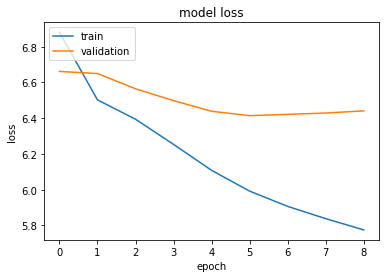

In [91]:
import matplotlib.pyplot as plt

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [103]:
# perplexity 
trained_model_loss = history.history['loss'][-1]
print("Trained model loss: %f"%trained_model_loss)
train_prp = np.exp(trained_model_loss)

validation_loss = history.history['val_loss'][-1]
print("Trained model validation loss: %f"%validation_loss)
validation_prp = np.exp(validation_loss)

Trained model loss: 5.774881
Trained model validation loss: 6.441102


In [104]:
print("Perplexity based on categorical cross entropy loss: ")
print("Train perplexity: %f" % train_prp)
print("Validation perplexity: %f" % validation_prp)

Perplexity based on categorical cross entropy loss: 
Train perplexity: 322.106081
Validation perplexity: 627.097649
